- import lib

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import demoji
import datetime

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/frostace/.conda/envs/bert_env/lib

Tensor Flow Version: 1.13.1
Keras Version: 2.2.4-tf

Python 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 1.0.1
Scikit-Learn 0.22.1
GPU is NOT AVAILABLE


- read data

In [2]:
tweet_vector_df = pd.read_csv("./data_vectors/vectors-100-2019-02-06.csv")

- SVD

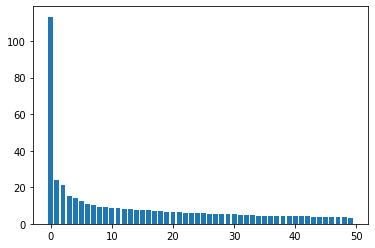

In [3]:
u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
num_of_bars = 50
_ = plt.bar(np.arange(num_of_bars), s[:num_of_bars])

In [4]:
threshold = 15

basis_events = []
for i in range(len(s)):
    if s[i] < threshold: break
    if s[i] >= threshold: basis_events.append(vh[i])

In [5]:
len(basis_events)

4

- project each non-basis vectors onto the basis vectors and aggregate them

In [6]:
aggregated_vector = [0 for i in range(768)]
for idx, tweet in tweet_vector_df.iterrows():
    # iterate through each basis event
    for basis_event in basis_events:
        norm = np.linalg.norm(basis_event)
        aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
#         print(np.dot(tweet.to_list(), basis_event))
#         print("==============")
# print(aggregated_vector)

- function to aggregate vector with projection

In [7]:
def aggregator(date):
    # read date
    tweet_vector_df = pd.read_csv("./data_vectors/vectors-100-" + date +".csv")
    
    # svd
    u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
    
    # generate basis events
    threshold = 15

    basis_events = []
    for i in range(len(s)):
        if s[i] < threshold: break
        if s[i] >= threshold: basis_events.append(vh[i])
    
    # projection
    aggregated_vector = [0 for i in range(768)]
    for idx, tweet in tweet_vector_df.iterrows():
        # iterate through each basis event
        for basis_event in basis_events:
            norm = np.linalg.norm(basis_event)
            aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
    return np.concatenate((np.array([date]), aggregated_vector))

- wrap up

In [10]:
# Inclusive on both sides
start_date = datetime.date(2019, 2, 6)
end_date = datetime.date(2020, 10, 14)
time_window = (end_date - start_date).days + 1

feature_by_date = pd.DataFrame(columns=["Date"] + [i for i in range(1, 769)])

for single_date in (start_date + datetime.timedelta(n) for n in range(time_window)): 
    this_date = single_date.strftime("%Y-%m-%d")
    new_row_df = pd.DataFrame(aggregator(this_date)).transpose()
    new_row_df = new_row_df.rename(columns={0: "Date"})
    feature_by_date = pd.concat([feature_by_date, new_row_df], ignore_index=True)
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("finished %s" % this_date)
    sys.stdout.flush()
print("\nall finished")

finished 2019-10-15

FileNotFoundError: [Errno 2] File ./data_vectors/vectors-100-2019-10-16.csv does not exist: './data_vectors/vectors-100-2019-10-16.csv'

In [11]:
feature_by_date

,Date,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,2019-02-06,21.811384980632212,-23.172494636262467,29.878425880228594,5.195662745930449,43.54330644802148,-21.582197346217782,-24.3702353793492,55.62456723370388,-24.491348509531424,...,-17.589252068256375,-8.227489806658344,-10.155242894598496,-10.2749480575347,37.738287551622406,2.997031767426396,-21.496688494823353,-47.371769209237705,17.51691036948624,9.489570515103601
1,2019-02-07,17.211354332361825,-14.679750602980963,27.988252016809202,3.515003120600909,26.570213820694367,-13.947232719686903,-11.697830043043812,48.06325206626863,-14.580819078861342,...,-10.356726136435471,-4.289624703290303,-10.100713216226675,-15.202135714869147,20.28693020091808,6.326297618406402,-13.710996896401799,-37.45777281897314,16.636176913061615,4.240559513313781
2,2019-02-08,11.186387630946744,-14.22899043041589,26.126609227352596,4.564928685219219,24.46711589261339,-12.933067758871696,-6.6132345328578035,39.69612075881164,-11.168660674306011,...,-12.043654742762854,-7.8666602063653785,-0.41410339765437953,-12.288814088709048,17.319789437593514,6.287599644981595,-11.422504846501885,-32.802381979648224,12.908284359339959,-3.924431876072964
3,2019-02-09,11.694692189813976,-5.085882447952392,17.668006836592753,1.2855236248669426,13.103755992425453,-10.038925732691183,-2.523657379115161,29.26801469337578,-8.630307575020321,...,-5.378833591646109,-2.687431725883362,-3.4871950440183066,-9.247129686273249,7.28020212724906,4.807832690464605,-7.099059201539622,-23.867946855001552,8.164817200534888,-0.5018109592393083
4,2019-02-10,10.609324978044803,-12.854321698100941,20.102872601781232,2.827437593946195,20.394200020441797,-10.748128101610547,-2.6850231850576045,35.618742154998046,-10.750333846809214,...,-8.3265645041943,-6.676086538067133,-3.481570409558958,-14.494114073969945,10.331560895519017,3.9958043327568835,-12.438085137403025,-28.145427485853062,4.942257744499713,1.5577654351421333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2019-10-11,7.815835630730518,-5.748726821953199,15.21792719901592,1.6077902120348617,16.241403465501627,-7.08559371577392,-1.4377575842657964,25.14136522464361,-7.193436664208233,...,-7.3118840312887,-5.409686827839536,-3.3168502604145282,-6.228811534454757,2.6977479628864436,4.877624581305126,-8.65893194480251,-24.295523292533243,4.227978724773377,2.6671556828997476
248,2019-10-12,6.143623471191387,-3.175615364247132,11.272915269345031,0.9277077512624397,8.462745717277082,-5.5677933092199146,-4.241675161398753,25.763966939128135,-6.101151464593281,...,-5.940297230143005,-6.973229206885221,2.470782856541487,-3.259541560540146,4.199658343579002,6.244744108851079,-4.476044524729397,-15.266199771094769,9.079048021320606,0.3211479496147081
249,2019-10-13,18.330629962933877,-9.643281455967548,20.82605868655422,3.5496774967393745,17.95138460351526,-12.50702313603557,-7.530561773360142,38.83191256054804,-10.120779505868333,...,-8.461454833427156,-4.066514670341688,-5.814751007314024,-14.91317220017243,8.92198311836508,8.934893998816122,-13.062394684288623,-26.786372386702958,13.477098256764231,0.016932368854482807
250,2019-10-14,9.693059036368183,-15.852689466727355,23.414626263762138,6.25777103066988,20.459513407416953,-8.90588290730152,-9.631196279570968,29.036692711861065,-8.685873527151804,...,-10.496261301191316,-4.735992841571318,1.823090395592831,-7.482430470208081,11.344104072727383,7.9783076769811965,-8.683424193220649,-25.375676346685157,10.90945015000496,-1.2122747438066772


In [12]:
feature_by_date.to_csv("aggregated_vector.csv", index=False)

- function to aggregate vector without projection

In [ ]:
def aggregator_naive(date):
    # read date
    tweet_vector_df = pd.read_csv("./data_vectors/vectors-100-" + date +".csv")

    basis_events = []
    for i in range(len(s)):
        if s[i] < threshold: break
        if s[i] >= threshold: basis_events.append(vh[i])
    
    # projection
    aggregated_vector = [0 for i in range(768)]
    for idx, tweet in tweet_vector_df.iterrows():
        # iterate through each basis event
        for basis_event in basis_events:
            norm = np.linalg.norm(basis_event)
            aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
    return np.concatenate((np.array([date]), aggregated_vector))